In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as special

pd.options.display.width = 10000
pd.options.display.max_columns = None

In [2]:
# read data from file 
with open("song_data.csv", "r") as file:
    df = pd.read_csv(file)
    
# remove nan values
df = df.dropna()

# global 
alpha = 0.05

print(df.head(10))

                    song_name  song_popularity  song_duration_ms  acousticness  danceability  energy  instrumentalness  key  liveness  loudness  audio_mode  speechiness    tempo  time_signature  audio_valence
0  Boulevard of Broken Dreams               73            262333      0.005520         0.496   0.682          0.000029    8    0.0589    -4.095           1       0.0294  167.060               4          0.474
1                  In The End               66            216933      0.010300         0.542   0.853          0.000000    3    0.1080    -6.407           0       0.0498  105.256               4          0.370
2           Seven Nation Army               76            231733      0.008170         0.737   0.463          0.447000    0    0.2550    -7.828           1       0.0792  123.881               4          0.324
3                  By The Way               74            216933      0.026400         0.451   0.970          0.003550    0    0.1020    -4.938           1       0.

### Построим гистограмму рейтинга песен 

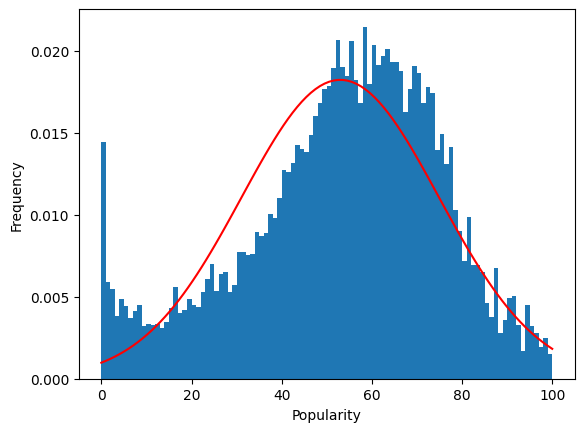

In [17]:
# plot the hist of how many sold
num_bins = 100
plt.hist(df['song_popularity'], bins=num_bins, density=True)
plt.xlabel('Popularity')
plt.ylabel('Frequency')

# normal distribution
x = np.linspace(min(df['song_popularity']), max(df['song_popularity']), 100)
mu = np.mean(df['song_popularity'])
sigma = np.std(df['song_popularity'])
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='red')
plt.show()

### Выдвинем статистическую гипотезу -- рейтинг песни распределен равномерно 
Пусть $F(x)$ -- закон распределения рейтинга песен. 
$$ 
\begin{array}{ll}
H_0 = \{F = N(\mu, \sigma^2)\} \\ 
H_1 = \{F \ne N(\mu, \sigma^2)\} \\ 
\end{array}
$$

Проверим гипотезу с помощью критерия Хи-квадрат.

Критерий $\chi^2$ основывается на группированных данных. Область значений предполагаемого распределения $F$ делят на некоторое число интервалов. После чего строят функцию отклонения $\rho$ по разностям теоретических вероятностей попадания в интервалы группировки и эмпирических частот.

Пусть $A_1, A_2,\ldots, A_k$ -- интервалы группировки, 

$\nu_j,~j = 1 \ldots k$ -- количество элементов выборки, попавших в интервал $A_j$, 

$p_j > 0$ -- вероятность попадания в интервал $A_j$ при условии верности нулевой гипотезы. 

$$
\rho = \sum_{j=1}^{k} \frac{(\nu_j - n p_j)^2}{n p_j}
$$

Если верна гипотеза $H_0$, то при фиксированном $k$ и $n \to \infty$ статистика $\rho$ имеет распределение $\chi^2$ с $k-1$ степенью свободы.

Построим критерий согласия: 
$$
\begin{cases}
H_0, & \text{если } \rho < C \\ 
H_1, & \text{если } \rho \ge C 
\end{cases}
$$
где $C$ -- квантиль распределения $\chi^2$ с $k-1$ степенью свободы уровня значимости $\alpha$.

In [9]:
n = len(df['song_popularity'])
imperial, bins = np.histogram(df['song_popularity'], bins=num_bins, density=True)

expected = stats.norm.pdf(bins[:-1], loc=mu, scale=sigma)

# вычислим статистику критерия 
p = sum([((imperial[i] - n * expected[i]) ** 2 / (n * expected[i])) for i in range(num_bins - 1)])
# print(p)

# вычислим критическое значение
с = stats.chi2.ppf(1 - alpha, num_bins - 1 - 1) 
p_value = 1 - stats.chi2.cdf(p, num_bins - 1 - 1)
# print(critical)

print(f"p={p}, с={с}", f"p_value={p_value}")

# проверим гипотезу
if abs(p) >= с:
    print('H0 is rejected')
else:
    print('H0 is not rejected')

p=18340.133103191074, с=122.10773460981942 p_value=0.0
H0 is rejected


Таким образом, можно опровергнуть гипотезу $H_0$ при уровне значимости $\alpha = 0.05$. Распределение рейтинга песен не является нормальным.

In [10]:
# проверка через встроенную функцию 
p_value = stats.kstest(imperial, 'norm', (mu, sigma)).pvalue
print(f"p_value={p_value}")

if p_value < alpha:
    print('H0 is rejected')
else:
    print('H0 is not rejected')

p_value=3.2049396358845108e-211
H0 is rejected


### Выдвинем статистическую гипотезу -- рейтинг коротких и длинных песен распределен одинаково

Пусть $F_{short}(x)$ -- закон распределения рейтинга коротких песен, $F_{long}(x)$ -- закон распределения рейтинга длинных песен.

$$
\begin{array}{ll}
H_0 = \{F_{short} = F_{long}\} \\
H_1 = \{F_{short} \ne F_{long}\}
\end{array}
$$

Short: 4088, Long: 4993


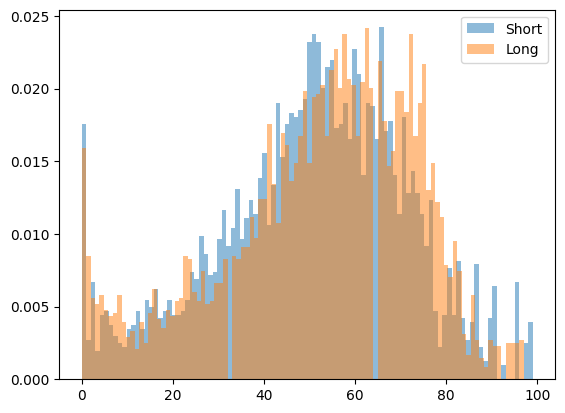

t=3.194776722310274, p_value=0.0014041752195860036 critical=1.960225310913378
H0 is rejected
t=3.1875775787426943, p_value=0.0014395643758633625 critical=1.960225310913378
H0 is rejected


In [11]:
# будем считать песни с длиной менее 180 секунд короткими, 
# а песни с длиной более 240 секунд длинными

short_time = 180 * 1000
long_time = 240 * 1000

short = df[df['song_duration_ms'] < short_time]
long = df[df['song_duration_ms'] > long_time]

print(f"Short: {len(short)}, Long: {len(long)}")

# Построим гистограммы 
plt.hist(short['song_popularity'], bins=num_bins, density=True, alpha=0.5)
plt.hist(long['song_popularity'], bins=num_bins, density=True, alpha=0.5)
plt.legend(['Short', 'Long'])
plt.show()

# t - test 
mean_short = np.mean(short['song_popularity'])
mean_long = np.mean(long['song_popularity'])

var_short = np.var(short['song_popularity'])
var_long = np.var(long['song_popularity'])

len_short = len(short)
len_long = len(long)

# статистика критерия
t = (mean_long - mean_short) / np.sqrt(var_short / len_short + var_long / len_long)
freedom_degree = len_short + len_long - 2
critical = stats.t.ppf(1 - alpha / 2, freedom_degree)  
p_value = 2 * stats.t.sf(abs(t), freedom_degree)
 
print(f"t={t}, p_value={p_value}", f"critical={critical}")

if t >= critical:
    print('H0 is rejected')
else:
    print('H0 is not rejected')
    
# проверка через встроенную функцию
t, p_value = stats.ttest_ind(long['song_popularity'], short['song_popularity'])
critical = stats.t.ppf(1 - alpha / 2, freedom_degree)
print(f"t={t}, p_value={p_value}", f"critical={critical}")

if p_value < alpha:
    print('H0 is rejected')
else:
    print('H0 is not rejected')

In [12]:
# Критерий Манна-Уитни
u, p_value = stats.mannwhitneyu(long['song_popularity'], short['song_popularity'])
critical = stats.norm.ppf(1 - alpha / 2)

print(f"u={u}, p_value={p_value}", f"critical={critical}")

if p_value < alpha:
    print('H0 is rejected')
else:
    print('H0 is not rejected')

u=10810001.5, p_value=1.1582076223851957e-06 critical=1.959963984540054
H0 is rejected


### Выдвинем статистическую гипотезу -- рейтинг песен связан с их танцевальностью 

$$
\begin{array}{ll}
H_0 = {K_{pr} = 0} \\ 
H_1 = {K_{pr} \ne 0}
\end{array}
$$
где $K_{pr}$ -- выборочный коэффициент корреляции.

Вычислим коэффициент корреляции формулой:
$$
K_{pr} = \frac{\sum{X_i\cdot Y_i - \overline{X} \cdot \overline{Y}}}{\sqrt{\sum{(Y_i - \overline{Y})^2}\cdot \sum{(X_i - \overline{X})^2}}}
$$

где $X_i$ -- рейтинг песни, $Y_i$ -- танцевальность песни, $\overline{X}$ -- средний рейтинг песен, $\overline{Y}$ -- средняя танцевальность песен.

In [13]:
mean_rating = df['song_popularity'].mean()
mean_danceability = df['danceability'].mean()
n = len(df)

s1 = (df['song_popularity'] * df['danceability'] - mean_danceability * mean_rating).sum() 
s2 = ((df['danceability'] - mean_danceability) ** 2).sum()
s3 = ((df['song_popularity'] - mean_rating) ** 2).sum()

K = s1 / np.sqrt(s2 * s3)

# статистика критерия
t_stat = K * np.sqrt(n - 2) / np.sqrt(1 - K ** 2)
p_value = 2 * (1 - stats.t.cdf(t_stat, n - 2))

print(f"correlation coefficient: {K}, t_stat: {t_stat}, p_value: {p_value}")

if p_value < alpha:
    print('H0 is rejected')
else:
    print('H0 is not rejected')

# проверка через встроенную функцию

K, p_value = stats.pearsonr(df['song_popularity'], df['danceability'])
t_stat = K * np.sqrt(n - 2) / np.sqrt(1 - K ** 2)
print(f"correlation coefficient: {K}, t_stat = {t_stat}, p_value: {p_value}")

if p_value < alpha:
    print('H0 is rejected')
else:
    print('H0 is not rejected')


correlation coefficient: 0.10429014168024378, t_stat: 14.390561373540615, p_value: 0.0
H0 is rejected
correlation coefficient: 0.10429014168024241, t_stat = 14.390561373540423, p_value: 1.0494366286773026e-46
H0 is rejected
